In [15]:
#Importing all required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from wordcloud import WordCloud
from nltk.stem import WordNetLemmatizer
import nltk
import subprocess
import re
from gensim.models import word2vec
from keras.preprocessing import text
from keras.utils import pad_sequences
from keras.layers import Embedding, SimpleRNN, Dense, Activation
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, BatchNormalization
from scikeras.wrappers import KerasClassifier
from keras.callbacks import EarlyStopping
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import LabelBinarizer




In [16]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Loading Dataset**

In [17]:
df= pd.read_json("/content/drive/MyDrive/Colab Notebooks/train.json")


In [18]:
df.head()

,id,cuisine,ingredients
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes..."
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g..."
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,22213,indian,"[water, vegetable oil, wheat, salt]"
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe..."


**Data preprocessing and EDA**

In [19]:
df["cuisine"].value_counts()

italian         7838
mexican         6438
southern_us     4320
indian          3003
chinese         2673
french          2646
cajun_creole    1546
thai            1539
japanese        1423
greek           1175
spanish          989
korean           830
vietnamese       825
moroccan         821
british          804
filipino         755
irish            667
jamaican         526
russian          489
brazilian        467
Name: cuisine, dtype: int64

In [20]:
#To check for null values
df.isnull().sum()

id             0
cuisine        0
ingredients    0
dtype: int64

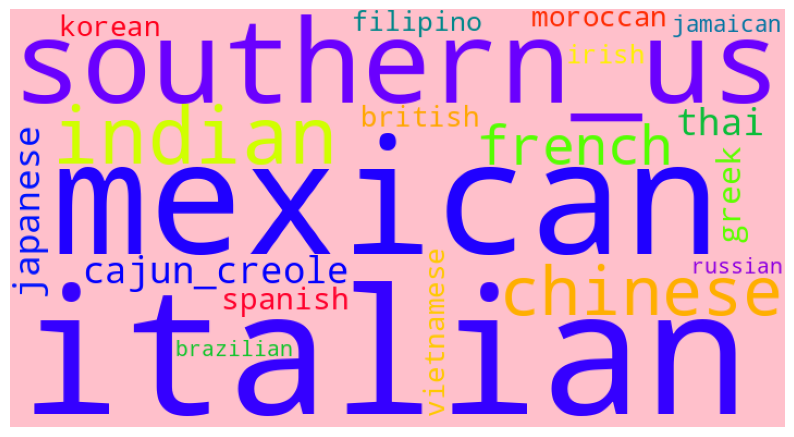

In [21]:
x= df['cuisine'].values

plt.subplots(figsize = (10,8))

wordcloud = WordCloud (
                    background_color = 'pink',
                    width = 712,
                    height = 384,
                    colormap = 'prism'    ).generate(' '.join(x))
plt.imshow(wordcloud) # image show
plt.axis('off') # to off the axis of x and y
plt.savefig('cuisines.png')
plt.show()

This shows us that italian is the most common cuisine in our dataset

Next we encode the cuisine column using LabelEncoder

In [22]:
#encode files
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(df.cuisine)



LabelEncoder()

In [23]:
#check for unique values
unique_values = df['cuisine'].unique()
unique_values

array(['greek', 'southern_us', 'filipino', 'indian', 'jamaican',
       'spanish', 'italian', 'mexican', 'chinese', 'british', 'thai',
       'vietnamese', 'cajun_creole', 'brazilian', 'french', 'japanese',
       'irish', 'korean', 'moroccan', 'russian'], dtype=object)

In [24]:
df['labeled'] = le.transform(df['cuisine'])

In [25]:
df

,id,cuisine,ingredients,labeled
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes...",6
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g...",16
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g...",4
3,22213,indian,"[water, vegetable oil, wheat, salt]",7
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe...",7
...,...,...,...,...
39769,29109,irish,"[light brown sugar, granulated sugar, butter, ...",8
39770,11462,italian,"[KRAFT Zesty Italian Dressing, purple onion, b...",9
39771,2238,irish,"[eggs, citrus fruit, raisins, sourdough starte...",8
39772,41882,chinese,"[boneless chicken skinless thigh, minced garli...",3


In [27]:
#Intialization of lemmetizer to take different versions of a word and turn them into a common, simplified version.
#"apples" -> "apple"
#"tomatoes" -> "tomato"
lemmetizer = WordNetLemmatizer()

def lemmetization(ls):
    regex = "[^A-Za-z]"
    text = [lemmetizer.lemmatize(re.sub(regex,"",x).lower()) for x in ls]


    return text

In [28]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [29]:
df['ingredients_lem'] = df['ingredients'].apply(lemmetization)


In [30]:
new = df[['labeled','ingredients_lem']]


In [31]:
new.head(5)

,labeled,ingredients_lem
0,6,"[romainelettuce, blackolives, grapetomatoes, g..."
1,16,"[plainflour, groundpepper, salt, tomato, groun..."
2,4,"[egg, pepper, salt, mayonaise, cookingoil, gre..."
3,7,"[water, vegetableoil, wheat, salt]"
4,7,"[blackpepper, shallot, cornflour, cayennepeppe..."


In [33]:
# Word2Vec model employed to learn vector representations for words based on their contexts in the given dataset of lemmatized ingredients.
downsampling = '1e-3'
model = word2vec.Word2Vec(new['ingredients_lem'].values,workers = 4, vector_size = 300, window = 10, epochs = 20)

In [34]:
#Used to find the words that are most similar to the word 'coffee' in the trained Word2Vec model
model.wv.most_similar(u'coffee')

[('instantespressopowder', 0.8520787954330444),
 ('chocolatesyrup', 0.8403483629226685),
 ('coffeegranules', 0.835237443447113),
 ('coffeeliqueur', 0.8329986333847046),
 ('kahla', 0.8103047013282776),
 ('espressobeans', 0.7978782653808594),
 ('chocolateshavings', 0.7978230118751526),
 ('brewedespresso', 0.7966106534004211),
 ('cooky', 0.79030442237854),
 ('coffeebeans', 0.7859776616096497)]

**Spliiting our data**

In [36]:
!pip install --upgrade keras


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 997.1/997.1 kB 11.7 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.14.0
    Uninstalling keras-2.14.0:
      Successfully uninstalled keras-2.14.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.14.0 requires keras<2.15,>=2.14.0, but you have keras 3.0.0 which is incompatible.


In [37]:
!pip install tensorflow


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 17.7 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.0.0
    Uninstalling keras-3.0.0:
      Successfully uninstalled keras-3.0.0


In [39]:
# Define the features and target variable from the DataFrame
x = new['ingredients_lem'].values  # Features (input)
y = new['labeled'].values            # Target variable (output)

# Split the data into a training set and a temporary test set (which will become validation and test sets)
x_train_temp, x_test_temp, y_train_temp, y_test_temp = train_test_split(x, y, test_size=0.3, random_state=42)

# Now split the temporary test set into the final validation and test sets
x_val, x_test, y_val, y_test = train_test_split(x_test_temp, y_test_temp, test_size=0.5, random_state=42)

# Now 70% of data in the training set, and 15% each in the validation and test sets.


In [40]:
#this function takes a list of ingredients and combines them into a single string where ingredients are separated by spaces
def str_to_arr(ls):
    text = ' '.join(ls)

    return text

In [41]:
#The str_to_arr function is essentially converting lists of lemmatized ingredients
#into a format where the ingredients are represented as a space-separated string.
new['ingredients'] = new['ingredients_lem'].apply(str_to_arr)


<ipython-input-41-ab200986c806>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new['ingredients'] = new['ingredients_lem'].apply(str_to_arr)


In [42]:
#calculation of the maximum length of strings in the 'ingredients' column and assigning to max_len
max_len = int(new['ingredients'].str.len().max())


In [43]:
max_len

902

In [44]:
#Adding a small constant value (such as 5) to the maximum length to provide a little extra buffer when padding sequences
maxlen5 = (max_len + 5)

In [45]:
maxlen5

907

In [47]:
# Initialize the tokenizer
token = Tokenizer(num_words=None)
token.fit_on_texts(list(x_train_temp) + list(x_val))

In [48]:
# Convert texts to sequences
train_seq = token.texts_to_sequences(list(x_train_temp))
val_seq = token.texts_to_sequences(list(x_val))
test_seq = token.texts_to_sequences(list(x_test))

In [49]:
# Pad the sequences
train_seq_pad = pad_sequences(train_seq, maxlen=maxlen5)
val_seq_pad = pad_sequences(val_seq, maxlen=maxlen5)
test_seq_pad = pad_sequences(test_seq, maxlen=maxlen5)

# Get the word index
word_index = token.word_index


.shape() to check that they all have the same shape

In [50]:
train_seq_pad.shape

(27841, 907)

In [51]:
val_seq_pad.shape

(5966, 907)

In [52]:
test_seq_pad.shape

(5967, 907)

### **TRAINING AND TESTING**


**SimpleRNN model**

In [53]:
# Create Model Archetecture
model = Sequential()
model.add(Embedding(len(word_index) + 1 , 300, input_length = maxlen5))
model.add(SimpleRNN(100))
model.add(Dense(20 , activation = 'softmax'))
model.compile(loss = 'SparseCategoricalCrossentropy', optimizer = 'adam', metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 907, 300)          1902300   
                                                                 
 simple_rnn (SimpleRNN)      (None, 100)               40100     
                                                                 
 dense (Dense)               (None, 20)                2020      
                                                                 
Total params: 1944420 (7.42 MB)
Trainable params: 1944420 (7.42 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [54]:
model.fit(train_seq_pad, y_train_temp , epochs = 1 , batch_size = 64)


436/436 [==============================] - 543s 1s/step - loss: 1.5785 - accuracy: 0.5378


In [55]:
model.evaluate(val_seq_pad, y_val)


187/187 [==============================] - 25s 132ms/step - loss: 1.1907 - accuracy: 0.6336


[1.1906969547271729, 0.6335903406143188]

In [56]:
model.evaluate(test_seq_pad, y_test)


187/187 [==============================] - 25s 136ms/step - loss: 1.2126 - accuracy: 0.6296


[1.2125563621520996, 0.6296296119689941]

**Other metrics**

In [57]:
# First, get the predictions for the validation set
val_predictions = model.predict(val_seq_pad)
val_predictions = val_predictions.argmax(axis=-1)  # Convert one-hot encoded predictions to class labels

# Now, get the predictions for the test set
test_predictions = model.predict(test_seq_pad)
test_predictions = test_predictions.argmax(axis=-1)  # Convert one-hot encoded predictions to class labels

# Calculate precision, recall, and F1 score for the validation set
val_precision = precision_score(y_val, val_predictions, average='macro')
val_recall = recall_score(y_val, val_predictions, average='macro')
val_f1_score = f1_score(y_val, val_predictions, average='macro')

# Calculate precision, recall, and F1 score for the test set
test_precision = precision_score(y_test, test_predictions, average='macro')
test_recall = recall_score(y_test, test_predictions, average='macro')
test_f1_score = f1_score(y_test, test_predictions, average='macro')

# Generate confusion matrices
val_confusion_matrix = confusion_matrix(y_val, val_predictions)
test_confusion_matrix = confusion_matrix(y_test, test_predictions)

# Print the metrics for validation set
print("Validation Precision:", val_precision)
print("Validation Recall:", val_recall)
print("Validation F1 Score:", val_f1_score)
print("Validation Confusion Matrix:\n", val_confusion_matrix)

# Print the metrics for test set
print("Test Precision:", test_precision)
print("Test Recall:", test_recall)
print("Test F1 Score:", test_f1_score)
print("Test Confusion Matrix:\n", test_confusion_matrix)


187/187 [==============================] - 27s 142ms/step
Validation Precision: 0.5216992417905639
Validation Recall: 0.41307535380371263
Validation F1 Score: 0.4256700011103309
Validation Confusion Matrix:
 [[  9   5   0   0   1  32   0   7   1   1   1   0   1   5   1   0   8   0
    5   0]
 [  0   8   0   0   0  97   0   1   4   0   0   1   0   0   0   0  17   0
    0   0]
 [  0   2 103   0   1  31   0   1   4  10   1   1   0   7   1   0  81   1
    0   0]
 [  0   3   0 307   4  18   0   2   2   4   2  10   5   0   0   0   1   0
    9   0]
 [  1   1   0  21  18  18   0   1   6   1   0   3   3   0   1   0   3   0
   17   1]
 [  0   2   1   1   0 366   0   0   1  24   1   2   0   2   1   0  21   1
    0   0]
 [  0   0   2   0   0  36  63   7   1  52   0   0   0   2   2   0   6   5
    0   0]
 [  1   0   0   0   1  16   1 398   1   5   0   1   0   8   4   0   1   1
    8   0]
 [  0   3   0   0   0  75   0   1   6   0   0   0   0   1   0   0  12   0
    0   0]
 [  0   0   1   0   0 290  

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [58]:
# Assuming 'y_test' are the true labels and 'test_predictions' are the predicted labels
# Create a DataFrame to display the comparison
comparison_df = pd.DataFrame({'Actual': y_test, 'Predicted': test_predictions})

# Display the first few entries in the DataFrame
print(comparison_df.head())


   Actual  Predicted
0      13         13
1      13         13
2       9          9
3       9          5
4      13         13


In [59]:
# Assuming 'le' is your LabelEncoder instance
# Assuming 'y_test' are the true labels and 'test_predictions' are the predicted labels

# Convert numerical labels to actual cuisine names
actual_cuisine_names = le.inverse_transform(y_test)
predicted_cuisine_names = le.inverse_transform(test_predictions)

# Create a DataFrame to display the comparison
comparison_df = pd.DataFrame({'Actual': actual_cuisine_names, 'Predicted': predicted_cuisine_names})

# Display the first few entries in the DataFrame
print(comparison_df.head())


    Actual Predicted
0  mexican   mexican
1  mexican   mexican
2  italian   italian
3  italian    french
4  mexican   mexican


**LSTM model**

To compare this model, we decided to build another model using LSTMs and pick the best

In [61]:
pip install scikeras

In [77]:
# Function to create model, required for KerasClassifier
def create_model(units=100, optimizer='adam'):
    model = Sequential()
    model.add(Embedding(len(word_index) + 1, 300, input_length=maxlen5))
    model.add(LSTM(units, return_sequences=True))
    model.add(BatchNormalization())  # Add batch normalization layer
    model.add(LSTM(units))
    model.add(BatchNormalization())  # Add another batch normalization layer
    model.add(Dense(20, activation='softmax'))
    model.compile(loss='SparseCategoricalCrossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Create model with default parameters
model = create_model()

# Fit the model
model.fit(train_seq_pad, y_train_temp, epochs=3, batch_size=74, callbacks=[early_stopping], verbose=1)

# Evaluate the model
loss, accuracy = model.evaluate(val_seq_pad, y_val)
print('Loss:', loss)
print('Accuracy:', accuracy)

# Uncomment the following lines if you want to perform grid search optimization later
# from sklearn.model_selection import GridSearchCV
# param_grid = {
#     'units': [20, 50],
#     'optimizer': ['rmsprop', 'adam'],
#     'batch_size': [64, 128],
#     'epochs': [1, 3, 5]
# }
# model = KerasClassifier(build_fn=create_model, units=100, optimizer='adam', verbose=2)
# grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
# grid_result = grid.fit(train_seq_pad, y_train_temp, callbacks=[early_stopping], verbose=1)
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))


Epoch 1/3
377/377 [==============================] - ETA: 0s - loss: 1.0841 - accuracy: 0.6856

377/377 [==============================] - 2113s 5s/step - loss: 1.0841 - accuracy: 0.6856
Epoch 2/3
377/377 [==============================] - ETA: 0s - loss: 0.5845 - accuracy: 0.8232

377/377 [==============================] - 2036s 5s/step - loss: 0.5845 - accuracy: 0.8232
Epoch 3/3
377/377 [==============================] - ETA: 0s - loss: 0.4175 - accuracy: 0.8697

187/187 [==============================] - 149s 792ms/step - loss: 0.9166 - accuracy: 0.7482
Loss: 0.9165648818016052
Accuracy: 0.748240053653717


In [78]:
model.evaluate(test_seq_pad, y_test)


187/187 [==============================] - 150s 802ms/step - loss: 0.9297 - accuracy: 0.7392


[0.9297300577163696, 0.7392324209213257]

In [79]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Assuming 'y_test' are the true labels for your test set
# And 'test_seq_pad' is the processed input data for the test set

# Get the predictions for the test set
test_predictions = model.predict(test_seq_pad)
test_predictions = test_predictions.argmax(axis=-1)  # Convert one-hot encoded predictions to class labels

# Calculate precision, recall, and F1 score for the test set
test_precision = precision_score(y_test, test_predictions, average='macro')
test_recall = recall_score(y_test, test_predictions, average='macro')
test_f1_score = f1_score(y_test, test_predictions, average='macro')

# Print the metrics for the test set
print("Test Precision:", test_precision)
print("Test Recall:", test_recall)
print("Test F1 Score:", test_f1_score)


187/187 [==============================] - 154s 807ms/step
Test Precision: 0.6621838684149861
Test Recall: 0.6491194582885277
Test F1 Score: 0.650740865592058


### **DEPLOYMENT**

Since the LSTM model preformed better than the SimpleRNN model we decided to Deploy that

In [80]:
model.save('my_model.h5')  # Creates a HDF5 file 'my_model.h5'


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [89]:
import joblib

# Save the tokenizer
tokenizer_filename = 'tokenizer.joblib'
joblib.dump(token, tokenizer_filename)



['tokenizer.joblib']

In [ ]:
# Save label encoder
joblib.dump(le, 'encoder.joblib')

# Save word index and max length as a dictionary
preprocessing_config = {
    'word_index': word_index,
    'max_length': maxlen5
}
joblib.dump(preprocessing_config, 'preprocessing_config.joblib')


In [88]:
# Assuming 'new' is your DataFrame with 'labeled' as the encoded labels
# and 'cuisine' as the actual cuisine names
new = df[['labeled', 'cuisine']]

# Drop duplicates to get unique pairs
unique_cuisines = new.drop_duplicates().set_index('labeled')

# Convert to dictionary
cuisine_label_mapping = unique_cuisines['cuisine'].to_dict()

# Now you can print or access the mapping
print(cuisine_label_mapping)

{6: 'greek', 16: 'southern_us', 4: 'filipino', 7: 'indian', 10: 'jamaican', 17: 'spanish', 9: 'italian', 13: 'mexican', 3: 'chinese', 1: 'british', 18: 'thai', 19: 'vietnamese', 2: 'cajun_creole', 0: 'brazilian', 5: 'french', 11: 'japanese', 8: 'irish', 12: 'korean', 14: 'moroccan', 15: 'russian'}
